# Matched wavelength photometry

**Version 0.1**

For today's problem, we will be perform matched-aperture photometry in 5 bands on multiple galaxies within a rich galaxy cluster. Ultimately, we will be looking for trends in galaxy colors and other properties as a function of cluster radius.

Note - we will use `astropy` for these tasks, though the use of [`Source Extractor`](https://www.astromatic.net/software/sextractor) is more standard within the galaxy community.


* * *

By M Alpaslan (NYU) & AA Miller (CIERA/Northwestern & Adler)

## Problem 0) Install photutils

If you have not already done so, install the [`photutils`](http://photutils.readthedocs.io/en/stable/index.html) package from the `astropy` conda channel *within your DSFP environment*. You will also need the [`scikit-image`](http://scikit-image.org) package.

    conda install -c astropy photutils
    conda install scikit-image

In [51]:
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, EllipticalAperture, EllipticalAnnulus
from photutils.segmentation import detect_sources, source_properties
from photutils.detection import detect_threshold
from photutils.centroids import centroid_com
from photutils import aperture_photometry
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) Download and Examine the Data

The images for this exercise can be downloaded from here: **URL needed**. Be sure to place the images in the same directory as this notebook (but do not add them to your git repo!).

Before we dive in, here is some background information on the images we will be analyzing: the imaging data and the group information all come from the [Galaxy And Mass Assembly (GAMA) survey](http://gama-psi.icrar.org/); and more specifically, its [panchromatic data release](https://arxiv.org/abs/1508.02076). 

Many of the difficult steps associated with multiband galaxy photometry have already been done for you: GAMA constructs large mosaics of co-added FITS images in 20 bands to measure photometry. The images we will use today are from the g, r, and i mosaics that I (MA) built $\sim$7 years ago. They are built from SDSS observations in those bands, and have all been convolved to a seeing of approximately 2”, background subtracted, and renormalized to a common zeropoint of 30 magnitudes. The group catalogue was done by Aaron Robotham (see https://arxiv.org/abs/1106.1994).

In the downloaded directory there are g, r, and i images of 36 galaxies that all belong to the same cluster. These image cutouts have been centered on the galaxy position, are $\sim$80.7" on a side, and have a pixel scale of $0.339"/\mathrm{pix}$.


To begin we will focus on a single galaxy, before eventually working on the entire cluster. 

**Problem 1a**

Display the $r$-band image of the galaxy 85698. Use a logarithmic stretch.

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


<IPython.core.display.Javascript object>


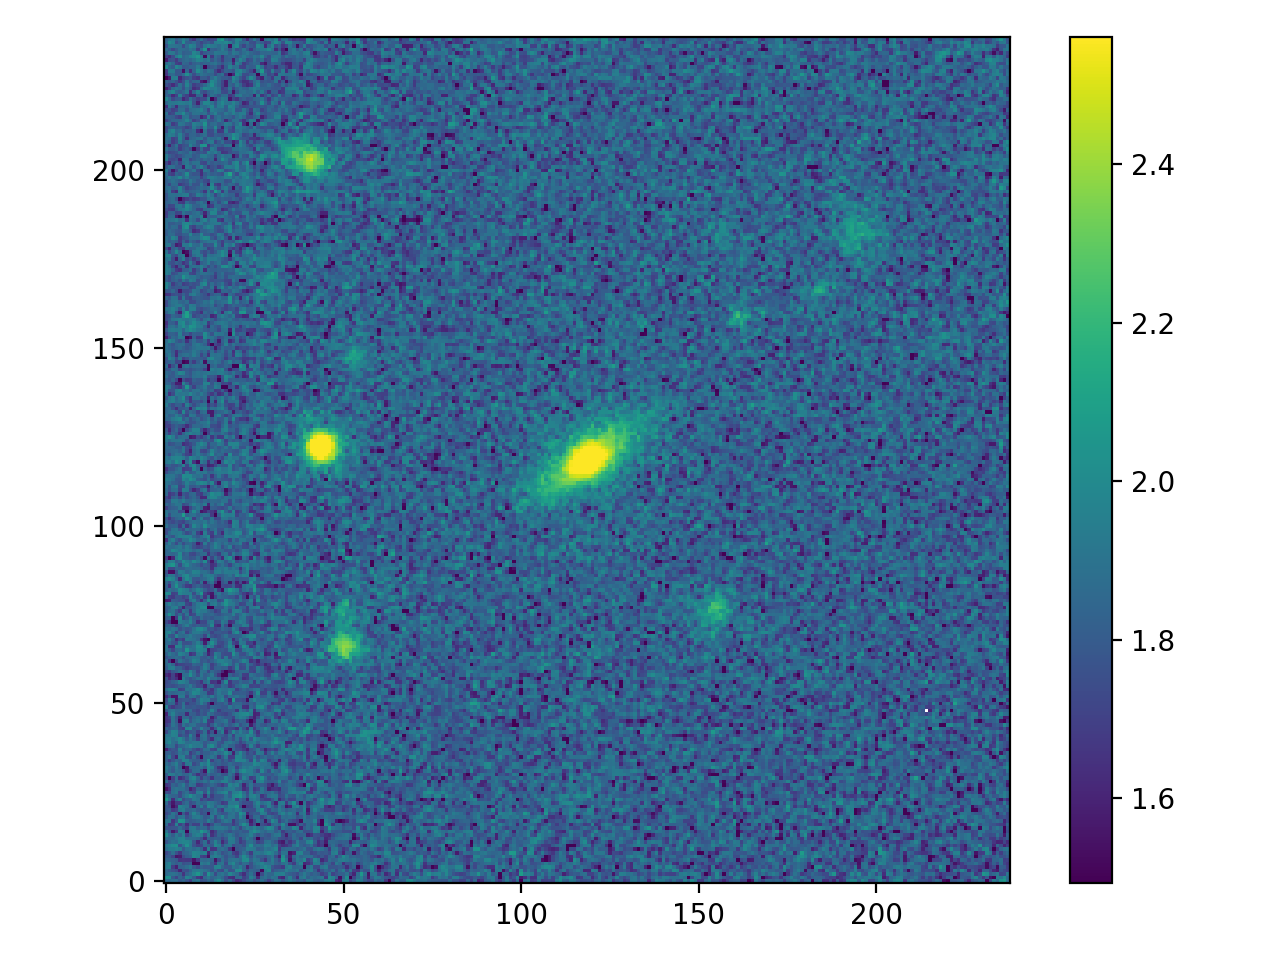

In [2]:
r_filename = "G200018/85698_sdss_r.fits"
r_data = fits.getdata(r_filename)

min_cnts = np.log10(np.percentile(r_data - np.min(r_data), 1))
max_cnts = np.log10(np.percentile(r_data - np.min(r_data), 99.85))

plt.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")

plt.colorbar()
plt.tight_layout()

**Problem 1b**

Roughly how many sources are present in the image?

*Hint* - an exact count is not required here.

**Solution 1b**

*Write your answer here*

## Problem 2) Source Detection

Prior to measuring any properties of sources in the image, we must first determine the number of sources present in the image. Source detection is challenging, and there are many different viable approaches. 

Today, we will streamline this step in order to spend more time focusing the issues associated with matching photometric measurements across different images. We will use the [`detect_sources`](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) function in `photutils` to identify objects in our image.

The simplest model assumes that the background is constant over the entire image. Once the background is determined, it can be subtracted from the image to determine high significance "peaks" corresponding to sources. After this week, we have learned that the background isn't so simple, nevertheless we will use the [`detect_threshold`](http://photutils.readthedocs.io/en/stable/api/photutils.detection.detect_threshold.html#photutils.detection.detect_threshold) convenience function to estimate *a constant* background for our images. `detect_threshold` produces a "detection image" that can be used to estimate the significance of the flux detected in any individual pixel.

**Problem 2a** 

Create a detection threshold image using the `detect_threshold` function.

In [3]:
threshold = detect_threshold(r_data, snr=3.)

**Problem 2b**

Develop better intuition for the detection image by plotting it side-by-side with the actual image of the field.

Do you notice anything interesting about the threshold image?

<IPython.core.display.Javascript object>


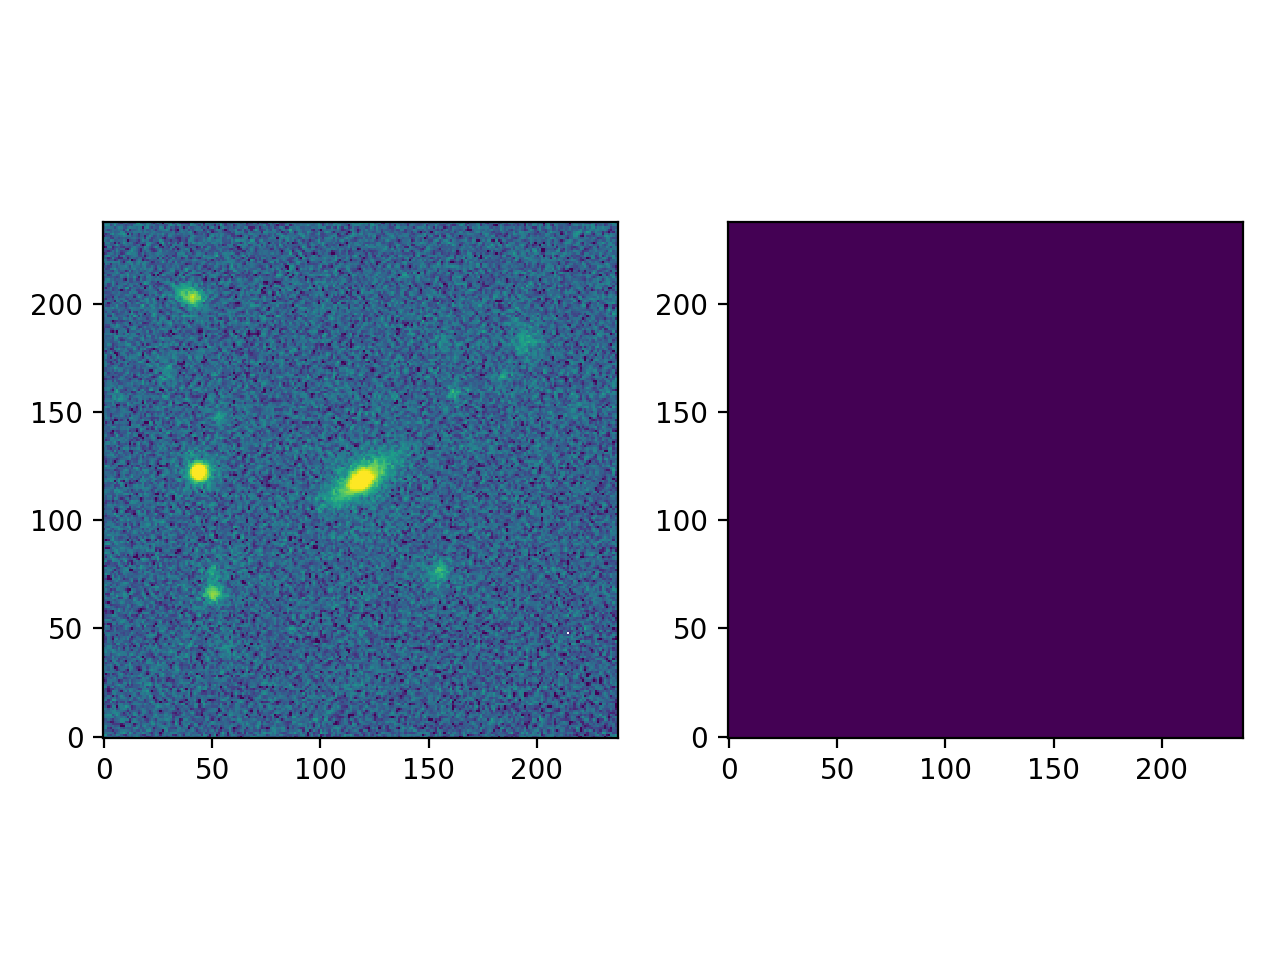

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax2.imshow(np.log10(threshold), 
           cmap='viridis', origin="lower")
fig.tight_layout()

Following this measurement of the background, we can find sources using the `detect_sources` function. Briefly, this function uses image segmentation to define and assign pixels to sources, which are defined as objects with $N$ connected pixels that are $s$ times brighter than the background (we already set $s = 3$). [Read the docs](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) for further details.

**Problem 2c**

Generate a segmentation image using `detect_sources`. Keep only sources with $N = 7$ pixels, which is keyword arg `npixels` in detect_sources.

*If you have extra time* Come back to this problem and see how changing $N$ affects your results.

In [5]:
segm = detect_sources(r_data, threshold, npixels=7)

**Problem 2d**

Plot the segmentation image side-by-side with the actual image of the field.

Are you concerned or happy with the results?

<IPython.core.display.Javascript object>


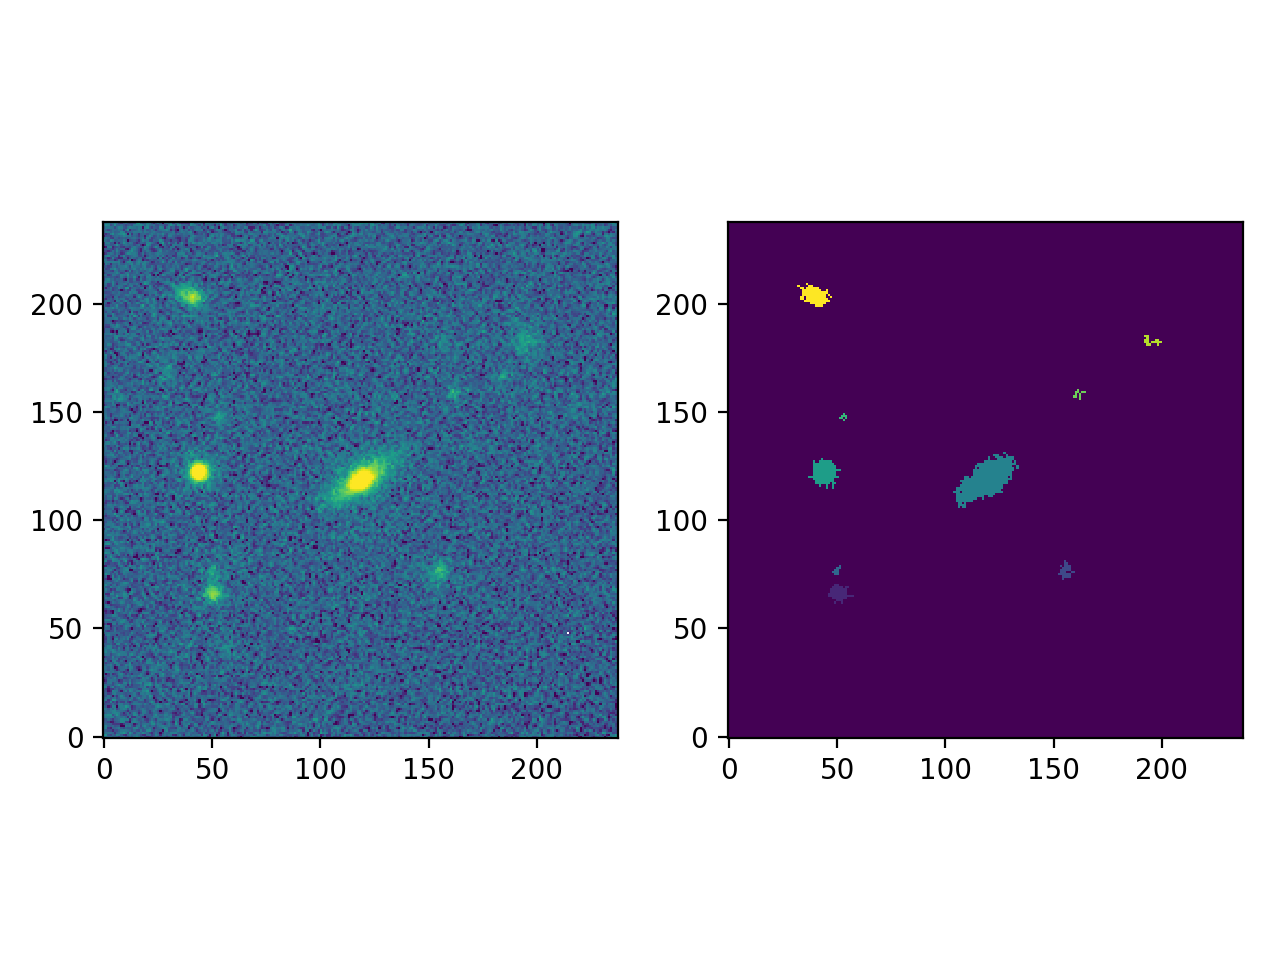

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax2.imshow(segm, 
           origin="lower")
fig.tight_layout()

## Problem 3) Source Centroids and Shapes

Now that we have defined all of the sources in the image, we must determine the centroid for each source (in order to ultimately make some form of photometric measurement). Like source detection, there are many ways to determine the centroid of a given source (e.g., fitting a model, finding the max of the marginalized 1-d distribution, etc). Today we will use the [`centroid_com`](http://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com) function, which calculates the "center of mass" of the 2d image moments to determine the source centroids.

To measure the centroid we want to isolate the source in question, thus we have generated a convenience function to return the extent of each source from its corresponding segmentation image.

In [7]:
def get_source_extent(segm_data, source_num):
    """
    Determine extent of sources for centroid measurements
    
    Parameters
    ----------
    segm_data : array-like
        Segementation image produced by photutils.segmentation.detect_sources
    
    source_num : int
        The source number from the segmentation image
        
    Returns
    -------
    source_extent : list
        The minimum y, maximum y, minimum x, and maximum x pixel values 
        over which a source is detected
    """
    source_pix = np.where(segm_data == source_num)
    source_extent = [np.min(source_pix[0]), np.max(source_pix[0]), 
                     np.min(source_pix[1]), np.max(source_pix[1])]

    return source_extent

**Problem 3a** 

Measure the centroid for each source detected in the image using the `centroid_com` function.

*Hint* - you'll want to start with a subset of pixels containing the source.

*Hint 2* - centroids are measured relative to the provided data, you'll need to convert back to "global" pixel values. 

In [8]:
xcentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")
ycentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")

for source_num in np.unique(segm.data)[1:]:
    source_extent = get_source_extent(segm.data, source_num)
    xc, yc = centroid_com(r_data[source_extent[0]:source_extent[1],
                                 source_extent[2]:source_extent[3]])
    xcentroid[source_num-1], ycentroid[source_num-1] = xc + source_extent[2], yc + source_extent[0]

**Problem 3b**

Overplot the derived centroids on the image data as a sanity check for your methodology.

<IPython.core.display.Javascript object>


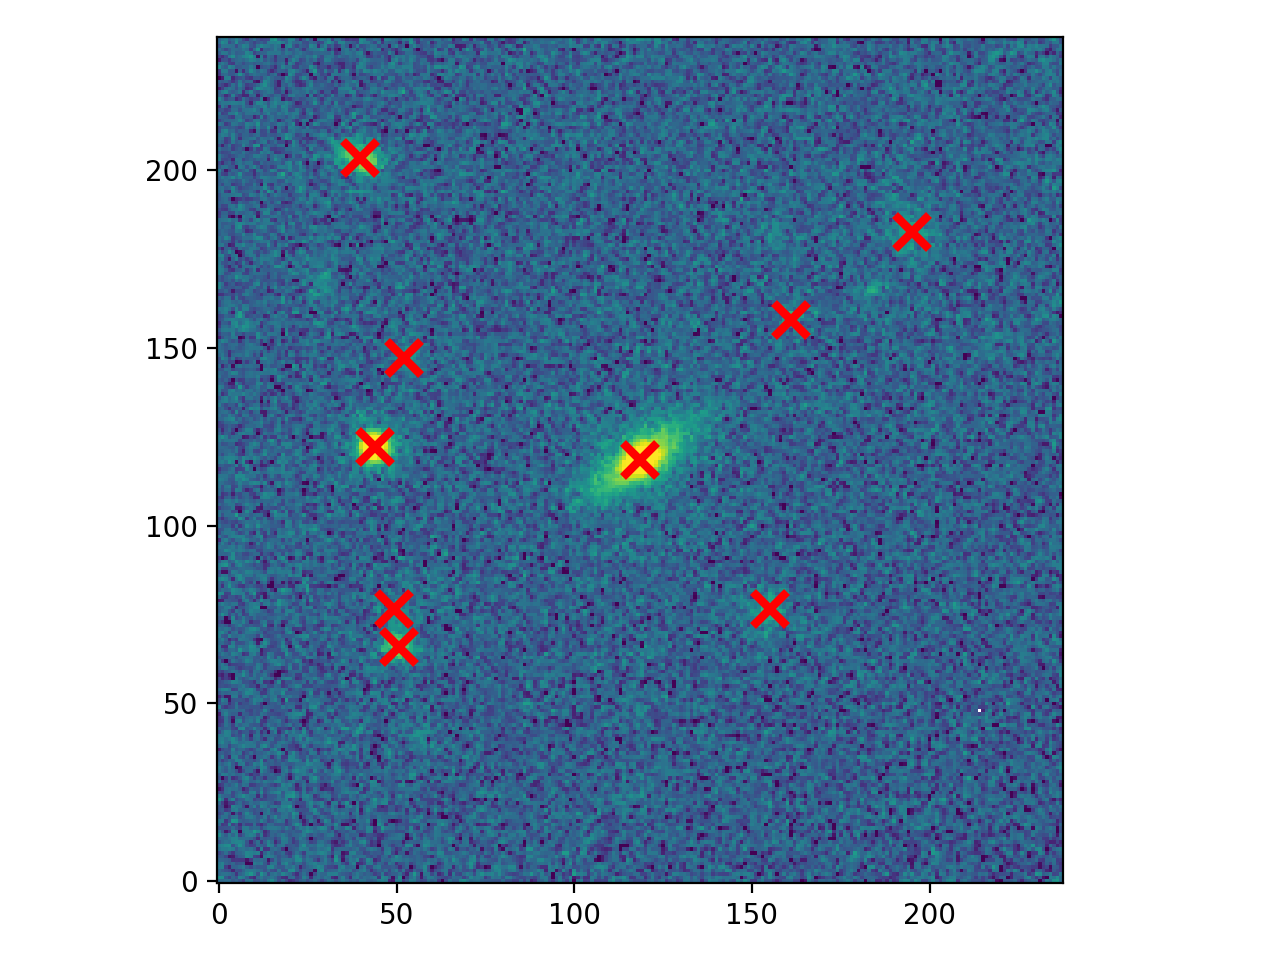

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
fig, ax1 = plt.subplots()

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax1.plot(xcentroid, ycentroid, 'x', color="red", ms=12, mew=3)
fig.tight_layout()

With an estimate of the centroid of every source in hand, we now need to determine the ellipse that best describes the galaxies in order to measure their flux. Fortunately, this can be done using the [`source_properties`](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.source_properties.html#photutils.segmentation.source_properties) function within [`photutils.morphology`](http://photutils.readthedocs.io/en/stable/morphology.html) package.

Briefly, `source_properties` takes both the data array, and the segmentation image as inputs, and then calculates properties for every source. The list of properties is long (see the attributes list), and for now we only care about the semi-major and semi-minor axes as well as the orientation of the source, all of which are needed to measure the flux in an elliptical aperture.

**Problem 3c**

Using `source_properties` determine $a$, $b$, and the orientation of each source.

In [17]:
cat = source_properties(r_data, segm)
tbl = cat.to_table(columns=['id', 'semimajor_axis_sigma','semiminor_axis_sigma', 'orientation'])

## Problem 4) Photometry

We now have all the necessary information to measure the flux in elliptical apertures. The [`EllipticalAperture`](http://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html#) function in `photutils` defines apertures on an image based on input centroids, $a$, $b$, and orientation values. 

**Problem 4a**

Define apertures for the sources that are detected in the image.

*Note* - the `semimajor_axis_sigma` reported by `source_properties()` is the "The 1-sigma standard deviation along the semimajor axis of the 2D Gaussian function that has the same second-order central moments as the source" [according to the docs](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties.semimajor_axis_sigma). Thus, be sure to multiple $a$ and $b$ by a factor of 3 in order to capture $\sim$99.7% of the source flux.

*Note to the note* - this isn't well motivated, but for the sake of argument assume that this adjustment creates a reasonable aperture.

In [46]:
positions = [(x,y) for x, y in zip(xcentroid, ycentroid)]

apertures = [EllipticalAperture(pos, a*3, b*3, theta) 
             for pos, a, b, theta in zip(positions, 
                                         tbl["semimajor_axis_sigma"].value, 
                                         tbl["semiminor_axis_sigma"].value, 
                                         tbl["orientation"].value)]

**Problem 4b** 

Overplot your apertures on the sources that have been detected.

*Hint* - each aperture object has a [`plot()`](http://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html#photutils.EllipticalAperture.plot) attribute that can be used to show the aperture for each source.

<IPython.core.display.Javascript object>


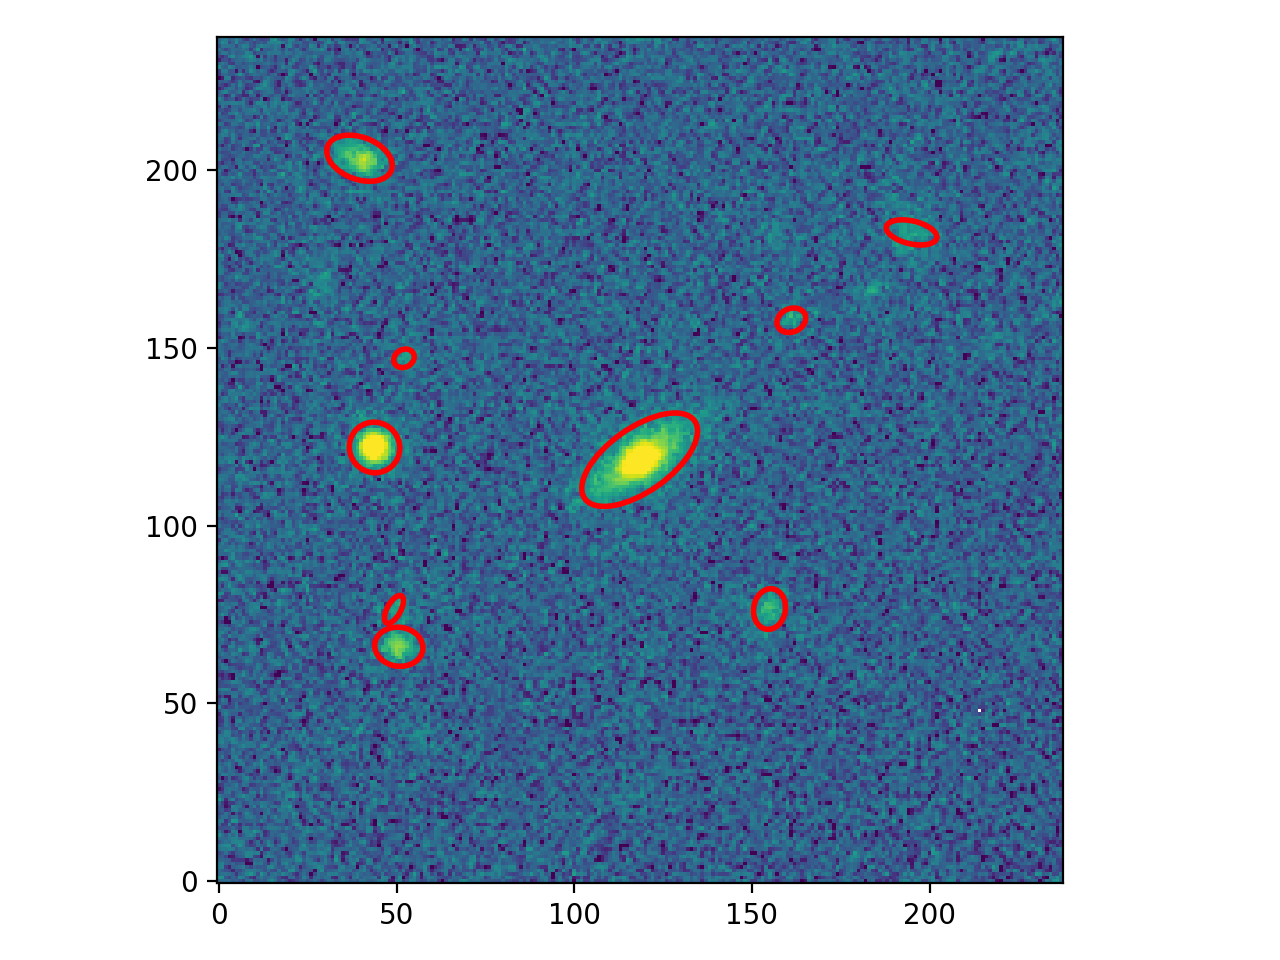

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
fig, ax1 = plt.subplots()

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
for ap in apertures:
    ap.plot(color="red", lw=2)
fig.tight_layout()

With apertures now defined, we can *finally* measure the flux of each source. The [`aperture_photometry`](http://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry) function returns the flux (actually counts) in an image for the provided apertures. It takes the image and apertures as arguments.

**Problem 4c**

Measure the counts detected from each source within the apertures defined in 4a. 

*Hint* - you will need to loop over each aperture as `aperture_photometry` does not take multiple apertures of different shapes as a single argument. 

In [77]:
source_cnts = np.empty_like(xcentroid)
# source_cnts_unc = np.empty_like(xcentroid)
for source_num, ap in enumerate(apertures):
    phot = aperture_photometry(r_data, ap)
    source_cnts[source_num] = float(phot["aperture_sum"])
#     source_cnts_unc[source_num] = float(phot["aperture_sum_err"])

The images have been normalized to a zero point of 30. Thus, we can convert from counts to magnitudes via the following equation: 

    $m = 30 - 2.5 \log (\mathrm{counts}).$

**Problem 4d**

Calculate the magnitude of each source in the image.

In [83]:
source_mag = 30 - 2.5*np.log10(source_cnts)

for source_num, mag in enumerate(source_mag):
    print("Source {:d} has m = {:.3f} mag".format(source_num+1, mag))

Source 1 has m = 20.308 mag
Source 2 has m = 20.994 mag
Source 3 has m = 22.356 mag
Source 4 has m = 17.888 mag
Source 5 has m = 18.864 mag
Source 6 has m = 22.572 mag
Source 7 has m = 22.089 mag
Source 8 has m = 21.350 mag
Source 9 has m = 19.788 mag


That's it! You've measured the magnitude for every source in the image.

As previously noted, the images provided for this dataset are centered are galaxies within a cluster, and ultimately, these galaxies are all that we care about. For this first image, that means we care about the galaxy centered at $(x,y) \approx (118, 118)$. 

**Problem 4e**

What is the magnitude of the galaxy we care about for this image? [We will need this moving forward]

In [84]:
for xc, yc, m in zip(xcentroid, ycentroid, source_mag):
    print(xc, yc, m)

50.6152180056 65.8730956851 20.3080973721
154.958361333 76.4878531805 20.9941565788
49.250986412 76.3845574541 22.355540438
118.407183441 118.520780845 17.8879264652
43.7817843744 121.966080414 18.8637101469
52.075775055 147.054363676 22.5724518281
161.104891921 157.770629918 22.088991231
194.935684194 182.498312437 21.3501054013
39.5491767178 203.372709117 19.7880995105


## Problem 5) Multiwavelength Photometry

Ultimately we want to measure colors for these galaxies. We now know the $r$ band magnitude for galaxy 85698, we would now like to know the $g$ and $i$ band magnitudes as well. 

**Problem 5a** Using the various pieces described above, write a function to measure the magnitude of the galaxy at the center of the image. 

*Hint* - creating an actual function is essential as we will eventually run this on every image. 

*Hint 2* - `source_properties` directly measures source centroids, use this it will be faster.

In [106]:
def cluster_galaxy_photometry(data):
    threshold = detect_threshold(data, snr=3.)
    segm = detect_sources(data, threshold, npixels=7)
    cat = source_properties(data, segm)
    tbl = cat.to_table(columns=['id', 'xcentroid', 'ycentroid', 
                                'semimajor_axis_sigma','semiminor_axis_sigma', 
                                'orientation'])
    cluster_idx = np.argmin(np.hypot(119-tbl['xcentroid'].value, 119-tbl['ycentroid'].value))
    
    xc = tbl[cluster_idx]["xcentroid"].value
    yc = tbl[cluster_idx]["ycentroid"].value
    a = 3*tbl[cluster_idx]["semimajor_axis_sigma"].value
    b = 3*tbl[cluster_idx]["semiminor_axis_sigma"].value
    theta = tbl[cluster_idx]["orientation"].value
    
    aperture = EllipticalAperture((xc, yc), a, b, theta)
    phot = aperture_photometry(data, aperture)
    mag = 30 - 2.5*np.log10(float(phot["aperture_sum"]))
    
    return mag

**Problem 5b**

Confirm that the function calculates the same $r$-band mag that was calculated in **Problem 4**.

In [114]:
func_mag = cluster_galaxy_photometry(r_data)

print("""Previously, we found m = {:.3f} mag. 
This new function finds m = {:.3f} mag.""".format(source_mag[3], func_mag))

Previously, we found m = 17.888 mag. 
This new function finds m = 17.888 mag


**Problem 5c** 

Use this new function to calculate the galaxy magnitude in the $g$ and the $i$ band, and determine the $g - r$ and $r - i$ colors of the galaxy.

In [117]:
g_data = fits.getdata("G200018/85698_sdss_g.fits")
i_data = fits.getdata("G200018/85698_sdss_i.fits")

g_mag = cluster_galaxy_photometry(g_data)
r_mag = cluster_galaxy_photometry(r_data)
i_mag = cluster_galaxy_photometry(i_data)

print("""The g-r color = {:.3f} mag.
The r-i color = {:.3f} mag""".format(g_mag - r_mag, r_mag - i_mag))

The g-r color = 1.267 mag.
The r-i color = 0.496 mag


But wait!

**Problem 5d**

Was this calculation "fair"?

*Hint* - this is a relatively red galaxy.

**Solution 5d**

This calculation was not "fair" because identical apertures were not used in all 3 filters. 

**Problem 5e** 

[Assuming your calculation was not fair] Calculate the $g - r$ and $r - i$ colors of the galaxy in a consistent fashion.

*Hint* - split your initial function into two functions, one to determine an aperture and another to measure photometry. Use the $r$-band image (where the signal-to-noise ratio of the data is highest) to define the aperture for all 3 images.

In [119]:
def cluster_galaxy_aperture(data):
    threshold = detect_threshold(data, snr=3.)
    segm = detect_sources(data, threshold, npixels=7)
    cat = source_properties(data, segm)
    tbl = cat.to_table(columns=['id', 'xcentroid', 'ycentroid', 
                                'semimajor_axis_sigma','semiminor_axis_sigma', 
                                'orientation'])
    cluster_idx = np.argmin(np.hypot(119-tbl['xcentroid'].value, 119-tbl['ycentroid'].value))
    
    xc = tbl[cluster_idx]["xcentroid"].value
    yc = tbl[cluster_idx]["ycentroid"].value
    a = 3*tbl[cluster_idx]["semimajor_axis_sigma"].value
    b = 3*tbl[cluster_idx]["semiminor_axis_sigma"].value
    theta = tbl[cluster_idx]["orientation"].value
    
    aperture = EllipticalAperture((xc, yc), a, b, theta)
    
    return aperture

def cluster_galaxy_phot(data, aperture):
    phot = aperture_photometry(data, aperture)
    mag = 30 - 2.5*np.log10(float(phot["aperture_sum"]))
    
    return mag

In [121]:
r_ap = cluster_galaxy_aperture(r_data)

g_mag = cluster_galaxy_phot(g_data, r_ap)
r_mag = cluster_galaxy_phot(r_data, r_ap)
i_mag = cluster_galaxy_phot(i_data, r_ap)

print("""The g-r color = {:.3f} mag.
The r-i color = {:.3f} mag.""".format(g_mag - r_mag, r_mag - i_mag))

The g-r color = 1.198 mag.
The r-i color = 0.538 mag


## Challenge Problem) Colors as a Function of Radius

Each of the provided FITS images corresponds to a single galaxy in the galaxy cluster. Measure the colors for each galaxy, and plot these colors as a function of cluster radius. The file **Add file name** provides the distance to the cluster center for each galaxy.